In [1]:
import numpy as np
from functools import partial
import pickle
import matplotlib.pyplot as plt

In [2]:
def rdm_padding(rdm, Z):
    num_orbitals = np.array([5 if z < 3 else 14 for z in Z])
    rdm_atom_start_indices = np.concatenate([[0], num_orbitals]).cumsum()
    insert_start_positions = rdm_atom_start_indices[1:][rdm_atom_start_indices[1:] - rdm_atom_start_indices[:-1] == 5]
    insertum = np.zeros((9, rdm.shape[1]))
    for index in reversed(insert_start_positions):
        rdm = np.insert(rdm, index, insertum, axis=0)
    rdm = rdm.T
    insertum = np.zeros((9, rdm.shape[1]))
    for index in reversed(insert_start_positions):
        rdm = np.insert(rdm, index, insertum, axis=0)
    for i in np.concatenate([[0], (14 * np.ones_like(Z, dtype=np.int32))[:-1]]).cumsum()[Z <= 2] + 2:
        rdm[:, [i, i + 1, i + 2, i + 3]] = rdm[:, [i + 3, i, i + 1, i + 2]]
        rdm[[i, i + 1, i + 2, i + 3], :] = rdm[[i + 3, i, i + 1, i + 2], :]
    return rdm

In [3]:
def rdm_reshape(rdm):
    side_length = len(rdm)
    n_atoms = side_length // 14
    rdm = np.reshape(rdm, (n_atoms, 14, n_atoms, 14))
    rdm = np.transpose(rdm, (0, 2, 1, 3))
    rdm = np.reshape(rdm, (n_atoms ** 2, 14, 14 ))
    return rdm

In [4]:
def add_Z_and_N(dict, Z):
    n_mols = len(dict["R"])
    N = Z.shape[0] * np.ones((n_mols,), dtype=np.int32)
    dict["Z"] = Z
    dict["N"] = N
    return dict

In [26]:
data = np.load("../../data/md_benzene.npz", allow_pickle=True)
#data = add_Z_and_N(data)
R = np.array([data[key]["R"].tolist() for key in list(data.keys())])
coords = np.array([data[key]["coords"].tolist() for key in list(data.keys())])
hf_density = np.array([data[key]["hf_density"].tolist() for key in list(data.keys())])
mp_density = np.array([data[key]["mp_density"].tolist() for key in list(data.keys())])
data = {
    "R": R,
    "coords": coords,
    "hf_density": hf_density,
    "mp_density": mp_density
}
Z = np.array([6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1])
data = add_Z_and_N(data, Z)

In [ ]:
rdm_hf = data["rdm_hf"]
rdm_hf = np.reshape(rdm_hf, (1200, 10, 10))
h2_rdm_pad = partial(rdm_padding, Z=np.array([1, 1]))
rdm_hf = np.vectorize(h2_rdm_pad, signature="(a,a)->(b,b)")(rdm_hf)
rdm_hf = np.vectorize(rdm_reshape, signature="(a,a)->(c,b,b)")(rdm_hf)
rdm_hf = np.reshape(rdm_hf, (rdm_hf.shape[0] * rdm_hf.shape[1], rdm_hf.shape[2], rdm_hf.shape[3]))
data["rdm_hf"] = rdm_hf
data["N_rdm"] = data["N"] ** 2

In [ ]:
with open("../../data/md_h2.npz", "wb") as f:
    pickle.dump(data, f)

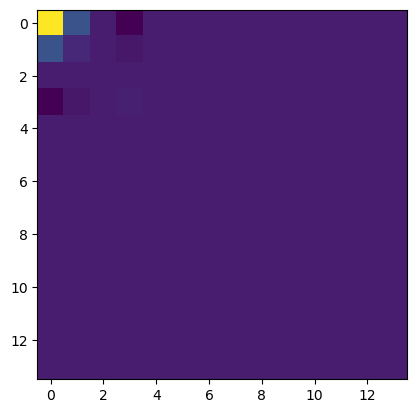

In [ ]:
plt.imshow(data["rdm_hf"][0])

In [ ]:
data["N_rdm"].sum()

4800